In [1]:
import pandas as pd
import numpy as np

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [2]:
df_orders = pd.read_csv('orders.csv')
df_orders['order_month'] = df_orders['order_date'].apply(lambda x: x[0:7])
df_orders['order_year'] = df_orders['order_date'].apply(lambda x: x[0:4])

In [3]:
df_customers = pd.read_csv('customers.csv')
cols = ['customer_id']
cols.extend(df_customers.columns[1:])
df_customers.columns = cols

In [4]:
df_orders.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year
888,106215,2015-04-16,Standard,BN-11470,12.576,2015-04,2015
2704,164035,2016-06-12,Standard,CR-12730,23.120,2016-06,2016
1068,120810,2015-07-23,Standard,TH-21550,197.760,2015-07,2015
4378,112508,2015-03-24,Standard,BP-11185,6.992,2015-03,2015
3233,121741,2017-12-26,Same Day,YC-21895,750.680,2017-12,2017


In [5]:
df_customers.sample(5)

,customer_id,name,segment,state,city
67,MG-17680,Maureen Gastineau,Home Office,Ohio,Newark
594,JM-16195,Justin MacKendrick,Consumer,California,Los Angeles
536,PB-19210,Phillip Breyer,Corporate,Oklahoma,Tulsa
512,CD-12280,Christina DeMoss,Consumer,Washington,Seattle
370,JJ-15445,Jennifer Jackson,Consumer,California,Los Angeles


In [6]:
df_merge = pd.merge(df_orders, df_customers, 'inner', on='customer_id')

In [7]:
df_first = df_merge.groupby('customer_id')['order_year'].min().reset_index()
df_first.columns = ['customer_id', 'first_order']

In [8]:
df_full = pd.merge(df_merge, df_first, 'inner', on='customer_id')

In [9]:
df_full.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city,first_order
3036,148782,2014-11-02,Standard,PO-18850,88.776,2014-11,2014,Patrick O'Brill,Consumer,Pennsylvania,Philadelphia,2014
78,112130,2015-05-03,Standard,SV-20785,1058.188,2015-05,2015,Stewart Visinsky,Consumer,Colorado,Pueblo,2014
1370,141558,2017-03-11,Standard,MH-17290,987.188,2017-03,2017,Marc Harrigan,Home Office,California,Los Angeles,2014
1448,144211,2016-08-28,Standard,CS-12130,124.056,2016-08,2016,Chad Sievert,Consumer,California,Los Angeles,2014
1692,158575,2016-11-18,Standard,SB-20290,103.968,2016-11,2016,Sean Braxton,Corporate,Texas,Houston,2014


In [28]:
df_cohort = df_full.groupby(['first_order', 'order_year']).agg(n_customers=('customer_id', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = df_cohort.order_year.astype(int) - df_cohort.first_order.astype(int)

In [29]:
df_cohort

,first_order,order_year,n_customers,period_number
0,2014,2014,595,0
1,2014,2015,437,1
2,2014,2016,485,2
3,2014,2017,517,3
4,2015,2015,136,0
5,2015,2016,102,1
6,2015,2017,120,2
7,2016,2016,51,0
8,2016,2017,45,1
9,2017,2017,11,0


In [17]:
cohort_pivot = df_cohort.pivot_table(index = 'first_order',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [18]:
cohort_pivot

period_number,0,1,2,3
first_order,,,,
2014,595.0,437.0,485.0,517.0
2015,136.0,102.0,120.0,NaN
2016,51.0,45.0,NaN,NaN
2017,11.0,NaN,NaN,NaN


In [19]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [20]:
retention_matrix

period_number,0,1,2,3
first_order,,,,
2014,1.0,0.734454,0.815126,0.868908
2015,1.0,0.750000,0.882353,NaN
2016,1.0,0.882353,NaN,NaN
2017,1.0,NaN,NaN,NaN


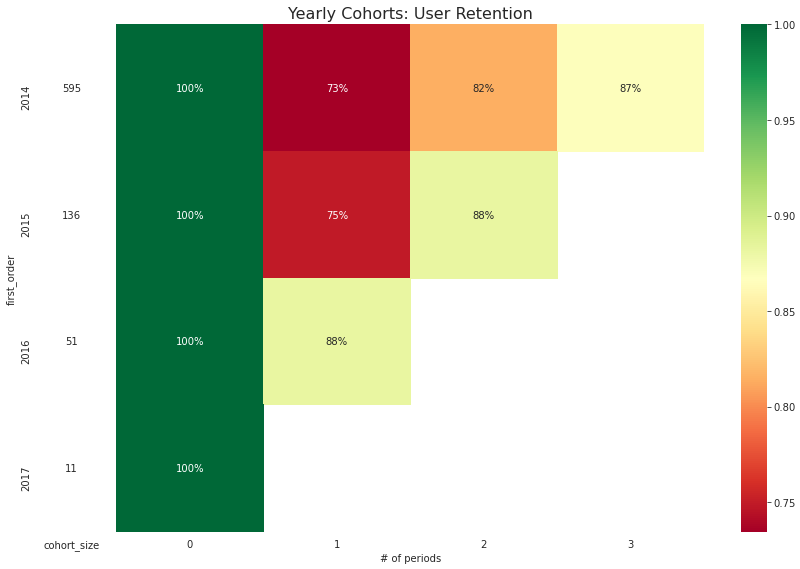

In [22]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Можно заметить, что количество пользователей уменьшается на следующий год после первого заказа (не все, кто совершает покупки, снова покупают что-то через год), но при этом с каждым последующим годом доля вернувшихся пользователей растёт, что характерно для каждого года присоединения пользователей. Также заметно, что вероятнее всего в 2017 году произошёл какой-то общий позитивный шок, который привёл к значительному увеличению доли тех, кто повторно совершает покупки во всех когортах. Особенно это заметно по доле 88% тех, кто совершил первую покупку в 2016 году, и вернулся в 2017 (в 2015 и 2014 доля повторных покупок через год меньше - 75% и 73%). Таким образом, нет доказательств гипотезы директора об увелечении оттока среди пользователей. Однако можно посмотреть на отдельные сегменты и виды доставок

In [65]:
df_cohort2 = df_full.groupby(['first_order', 'order_year','segment']).agg(n_customers=('customer_id', 'nunique')).reset_index(drop=False)
df_cohort2['period_number'] = df_cohort2.order_year.astype(int) - df_cohort2.first_order.astype(int)

In [66]:
df_cohort2_1 = df_cohort2[df_cohort2.segment == 'Consumer']

In [67]:
cohort_pivot = df_cohort2_1.pivot_table(index = 'first_order',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [68]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

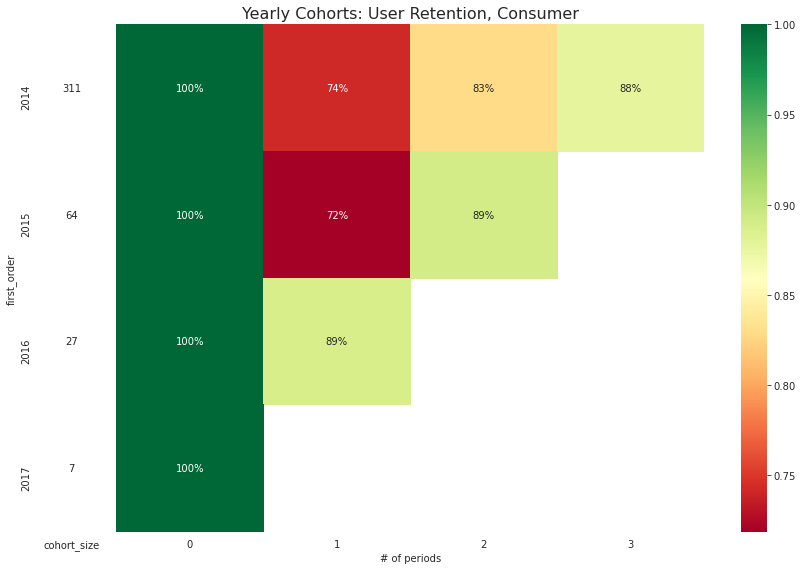

In [69]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention, Consumer', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Среди потребительских товаров ситуация идентична описанной выше. В 2017 доля вернувшихся пользователей растёт во всех когортах таким образом, что доля становятся примерно равны. 

In [36]:
df_cohort2_2 = df_cohort2[df_cohort2.segment == 'Corporate']

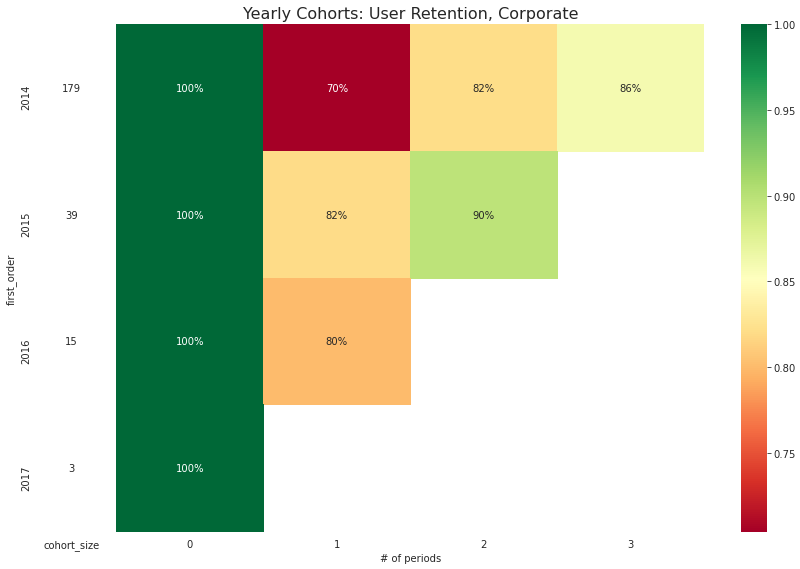

In [59]:
cohort_pivot = df_cohort2_2.pivot_table(index = 'first_order',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention, Corporate', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

В этой категории товаров опять заметен рост доли покупателей потвторно совершающих покупки в 2017 году, однако особенно выделяется группа покупателей, совершивших первую покупку в 2015, так как здесь наибольшее количество вернувшихся покупателей (90%). Среди покупателей, совершивших первую покупку в 2016, в 2017 вернулись лишь 80%, что меньше, чем в остальных группах этой категории товаров. 

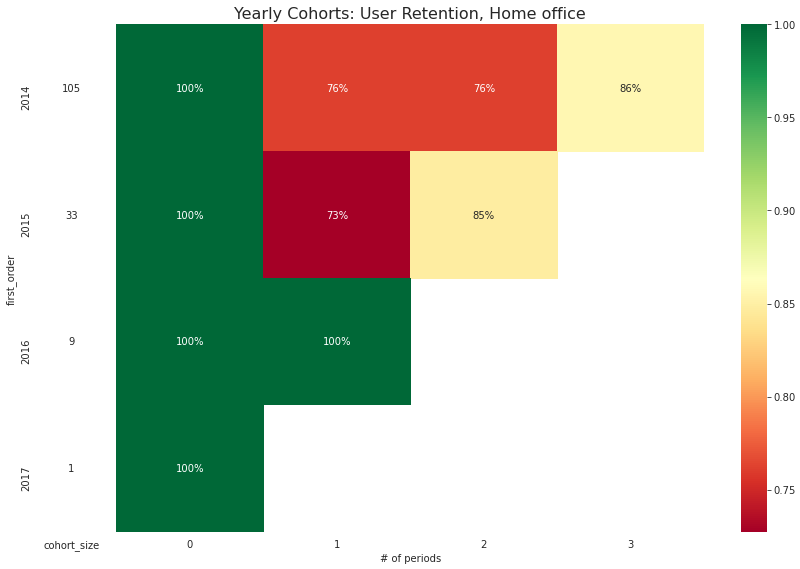

In [58]:
df_cohort2_3 = df_cohort2[df_cohort2.segment == 'Home Office']
cohort_pivot = df_cohort2_3.pivot_table(index = 'first_order',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention, Home office', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Что касается товров этой категории, то здесь все покупатели, совершившие первую покупку в 2016, повторно совершили покупку в 2017. Наиболее большой отток пользователей - среди тех, кто присоединился в 2015, однако при этом в 2017 доля повторных покупок всё же растёт. 

In [45]:
df_cohort3 = df_full.groupby(['first_order', 'order_year','ship_mode']).agg(n_customers=('customer_id', 'nunique')).reset_index(drop=False)
df_cohort3['period_number'] = df_cohort3.order_year.astype(int) - df_cohort3.first_order.astype(int)

In [56]:
df_cohort3_1 = df_cohort3[df_cohort3.ship_mode == 'First']

,first_order,order_year,ship_mode,n_customers,period_number
0,2014,2014,First,132,0
4,2014,2015,First,104,1
8,2014,2016,First,137,2
12,2014,2017,First,168,3
16,2015,2015,First,29,0
20,2015,2016,First,37,1
24,2015,2017,First,44,2
28,2016,2016,First,18,0
32,2016,2017,First,21,1
36,2017,2017,First,3,0


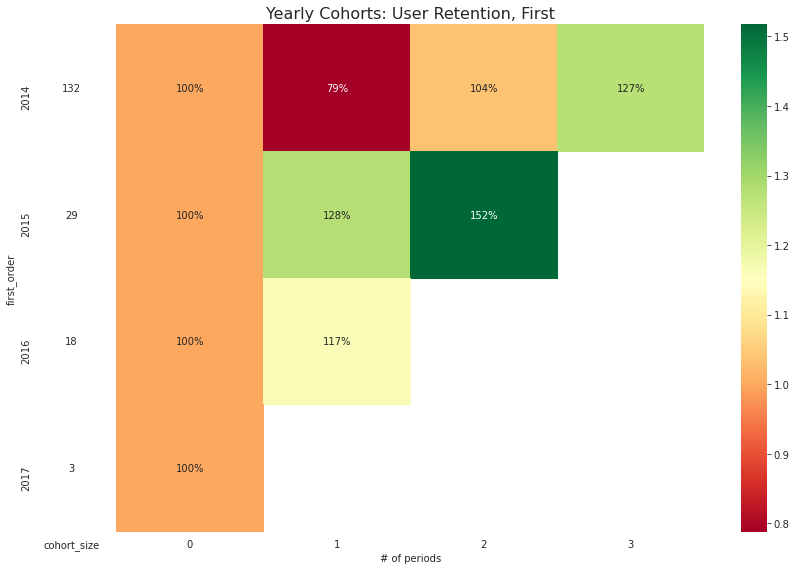

In [57]:
cohort_pivot = df_cohort3_1.pivot_table(index = 'first_order',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention, First', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Анализировать по виду доставки сложнее, так как в изначальную выборку входят клиенты, выбравшие определённую доставку, а в последующих годах присоединятся покупатели с тем же годом первого заказа, но другим видом первой доставки, поэтому доля вернувшихся пользователей может превышать 100%. Однако в целом видно, что доля покупателей, выбирающих First ship_mode, растёт среди всех групп покупаталей. Особенно большой рост в 2017 у тех, кто совершил первую покупку в 2015.

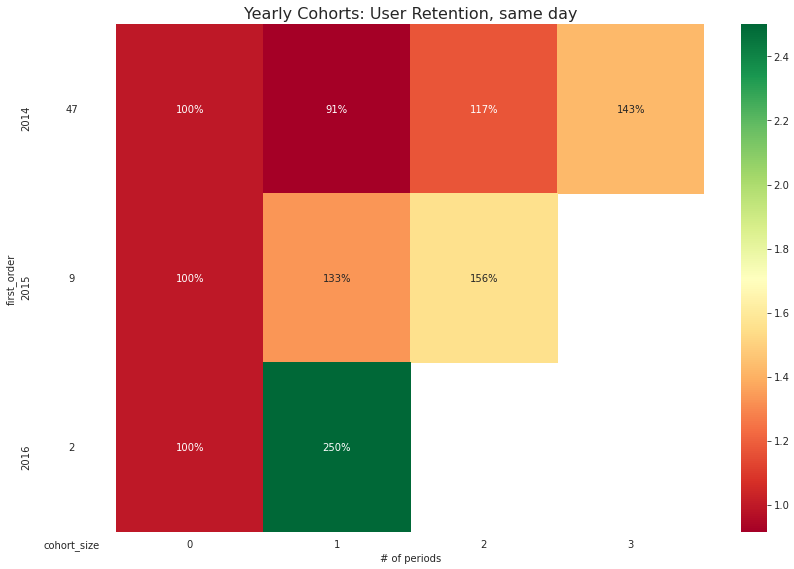

In [55]:
df_cohort3_2 = df_cohort3[df_cohort3.ship_mode == 'Same Day']
cohort_pivot = df_cohort3_2.pivot_table(index = 'first_order',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention, same day', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

У доставки в тот же день наибольшая доля пользовтелей, выбирающих её. Так, например, для этого вида доставки количество клиентов, совершивших первую покупку в 2016, увеличилось более, чем в 2 раза. 

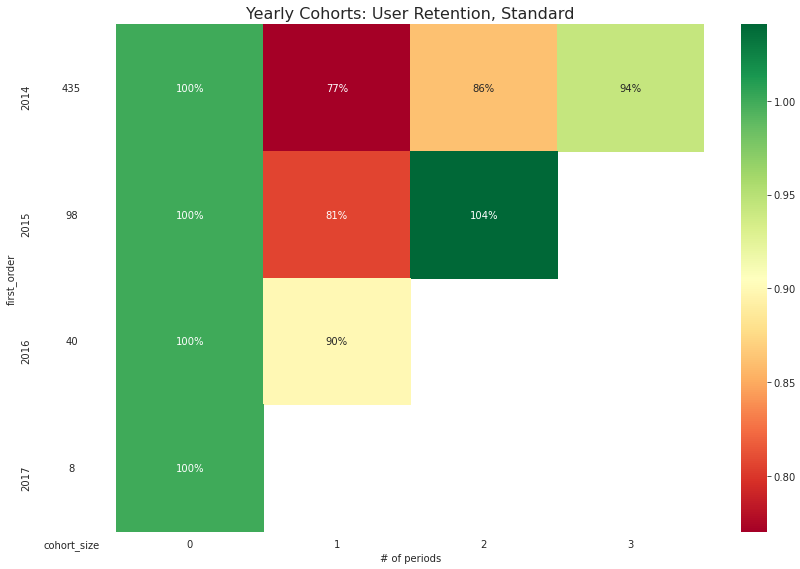

In [54]:
df_cohort3_3 = df_cohort3[df_cohort3.ship_mode == 'Standard']
cohort_pivot = df_cohort3_3.pivot_table(index = 'first_order',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention, Standard', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

По сравнению с остальными видами доставок количество пользователей, выбирающих стандартную дотсавку, уменьшилось.

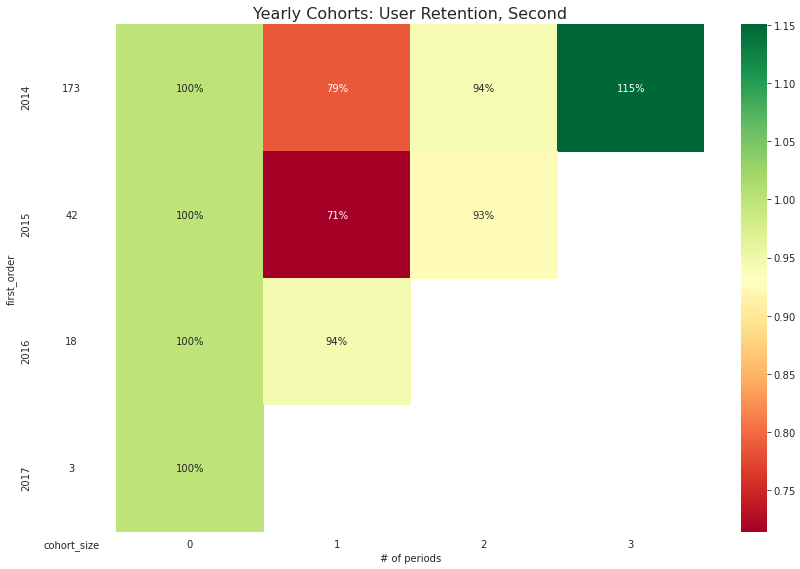

In [53]:
df_cohort3_4 = df_cohort3[df_cohort3.ship_mode == 'Second']
cohort_pivot = df_cohort3_4.pivot_table(index = 'first_order',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention, Second', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Доля клиентов, выбирающих эту доставку, также уменьшается. Например, среди тех, кто совершил первую покупку в 2015, только 71% выбрали её через год, через два года доля составила 93%, но это всё равно меньше, чем, например, у доставки в тот же день.

Таким образом, нельзя сделать вывод об увеличении оттока пользователей из-за поблем с дотавкой, так как по большинству групп доля покупателей, повторно совершающих покупки, увиличивается в 2017 сильнее, чем в 2016. Доля покупателей, вернувшихся через год выше среди тех, кто присоединился в 2016, чем среди тех, кто присоединился в 2015, Более того для последних, доля вернувшихся через два года также увеличивается. Вероятнее всего, в 2017 году произошли положительные изменения, повлиявшие на общий retention rate.

Что касается доставки, заметно, что большее количество людей стало переключаться на доставку первого класса или в тот же день. 

Используя эти графики и имея больше информации о происходящих в магазине процессах, можно принять решение по качеству удержания клиентской базы